<h2> Redes Neurais e Aprendizado Profundo <h2>

- Regularização com Dropout, Batch Normalization e Early Stopping


## Parte 0 - Bibliotecas e Dataset

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [ ]:
#Padronizando sememente aleatória
torch.manual_seed(123)

#Device
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

#Transformando dados para o tensor
transform = transforms.ToTensor()
#Tamanho de Batch
bs = 128

#Conjunto de treinamento CIFAR 10
train = datasets.CIFAR10(root = '.', train = True, download = True, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)

#Conjunto de teste CIFAR 10
test = datasets.CIFAR10(root = '.', train = False, download = True, transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=bs, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Checando o dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


## Parte 1 - CNN Simples sem técnicas de Regularização

Construção de uma arquitetura simples de um CNN.
A ideia é fazer um comparativo com as redes seguintes.

In [ ]:
#Construção de uma CNN simples
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        self.relu = nn.ReLU()
        self.maxpooling = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):

        out = self.maxpooling(self.relu(self.conv1(x)))
        out = self.maxpooling(self.relu(self.conv2(out)))

        out = out.view(out.size(0), -1)
        out = self.flatten(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)

        return out

In [ ]:
#Função para calcular a loss no conjunto de teste
def net_validation(model, test_loader, loss_function):

    model.eval()
    loss_total = 0.0

    with torch.no_grad():
        for features, targets in test_loader:
            #Transferindo as imagens e labels para a GPU
            features = features.to(device)
            targets = targets.to(device)
            output = model(features)
            loss = loss_function(output, targets)
            loss_total += loss.item()

    return loss_total/len(test_loader)


#Função para calcular a acurácia da rede
def net_accuracy(model, data_loader):

  correct_pred = 0
  num_examples = 0

  for i, (inputs, labels) in enumerate(data_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    logits = model(inputs)
    _, predicted_labels = torch.max(logits, 1)
    num_examples += labels.size(0)
    correct_pred += (predicted_labels == labels).sum()

  return correct_pred.float()/num_examples*100


#Função de treinamento da rede
def net_training(model, epochs, optimizer, loss_function, train_loader, test_loader):

    model.to(device)
    training_loss, testing_loss = [], []


    for epoch in range(1, epochs):
        model.train()
        running_loss = .0
        for batch_count, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            output = model(features)
            loss = loss_function(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()#Armazenando as loss em uma lista


        avg_train_loss = running_loss/batch_count
        avg_test_loss = net_validation(model, test_loader, loss_function)
        training_loss.append(avg_train_loss)
        testing_loss.append(avg_test_loss)

        print("Epoch:", epoch, "| Loss:", avg_train_loss)


        #Calculando a acurácia da rede
        model.eval()
        with torch.no_grad():
            print('Época: %03d/%03d acurácia de treinamento: %.2f%%' % (epoch, epochs,
                                                              net_accuracy(model, train_loader)))


    return training_loss, testing_loss

In [ ]:
#Instanciando a nossa CNN simples sem regularição
simple_cnn = CNN()

#Função de custo/perda/loss
criterion = nn.CrossEntropyLoss()

#Taxa de aprendizagem
learning_rate = 0.001

#Optimizador
optimizer = optim.Adam(simple_cnn.parameters(), lr = learning_rate)

total_params = sum(p.numel() for p in simple_cnn.parameters())
print(f"Número de parâmetros da rede: {total_params}\n")

Número de parâmetros da rede: 332234



In [ ]:
#Número de Épocas
num_epochs = 25

#Armazenando tempo inicial
start_time = time.time()

#Treinando a nossa rede
simple_cnn_loss_train, simple_cnn_loss_test = net_training(model = simple_cnn,
                                        epochs = num_epochs,
                                        optimizer = optimizer,
                                        loss_function = criterion,
                                        train_loader = train_loader,
                                        test_loader = test_loader
                                        )

#Tempo total de treinamento
print('\nTempo de treino total:: %.2f min' % ((time.time() - start_time)/60))

#Avaliação com o conjunto de teste
print('\nAcurácia do modelo no conjunto de teste: %.2f%%' % (net_accuracy(simple_cnn, test_loader)))

Epoch: 1 | Loss: 1.6581651611205859
Época: 001/025 acurácia de treinamento: 48.33%
Epoch: 2 | Loss: 1.32265096505483
Época: 002/025 acurácia de treinamento: 55.33%
Epoch: 3 | Loss: 1.1657376679090352
Época: 003/025 acurácia de treinamento: 61.76%
Epoch: 4 | Loss: 1.0569438827343476
Época: 004/025 acurácia de treinamento: 65.80%
Epoch: 5 | Loss: 0.9736375434276385
Época: 005/025 acurácia de treinamento: 67.98%
Epoch: 6 | Loss: 0.913401417243175
Época: 006/025 acurácia de treinamento: 70.52%
Epoch: 7 | Loss: 0.8617286587372804
Época: 007/025 acurácia de treinamento: 71.87%
Epoch: 8 | Loss: 0.8082707044405815
Época: 008/025 acurácia de treinamento: 73.82%
Epoch: 9 | Loss: 0.769672676997307
Época: 009/025 acurácia de treinamento: 73.77%
Epoch: 10 | Loss: 0.7240505563907135
Época: 010/025 acurácia de treinamento: 77.46%
Epoch: 11 | Loss: 0.6883069353990066
Época: 011/025 acurácia de treinamento: 78.66%
Epoch: 12 | Loss: 0.6460119174841122
Época: 012/025 acurácia de treinamento: 78.61%
Epoch

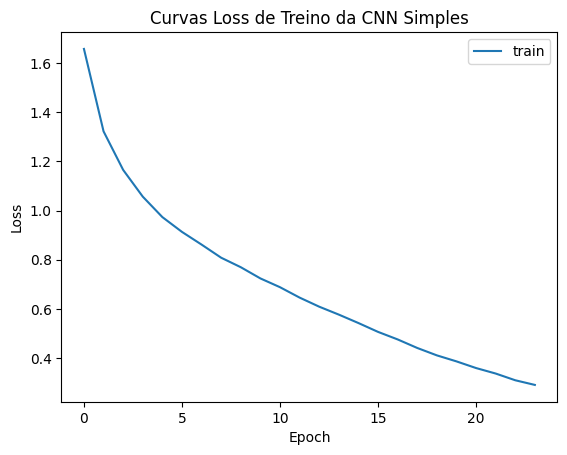

In [ ]:
#Plotando a curva de Loss do modelo CNN Simples
plt.plot(simple_cnn_loss_train, label="train")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.title("Curvas Loss de Treino da CNN Simples")
plt.show()

## Parte 2 - CNN com Dropout e Batch Normalization

**Dropout:** é uma técnica de regularização para modelos de redes neurais proposta por Srivastava, et al. em seu artigo de 2014 Dropout: A Simple Way to Prevent Neural Networks from Overfitting: https://jmlr.org/papers/v15/srivastava14a.html.

- O dropout é uma técnica onde os neurônios selecionados são aleatoriamente ignorados durante o treino.
- Eles são "abandonados" aleatoriamente. Isto significa que a sua contribuição para a ativação dos neurônios é temporariamente removida na passagem para a frente (forward) e quaisquer atualizações de peso não são aplicadas ao neurônio na passagem para trás (backward).




**Batch Normalization:** é um método algorítmico que torna o treinamento de Deep Neural Networks (DNN) mais rápido e estável.
- Consiste em normalizar os vetores de ativação das camadas ocultas usando o primeiro e o segundo momentos estatísticos (média e variância) do lote atual. Essa etapa de normalização é aplicada antes (ou logo depois) da função não linear.


In [ ]:
#Construção de uma CNN com os regularizadores dropout e batch normalization
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        self.relu = nn.ReLU()
        self.maxpooling = nn.MaxPool2d(kernel_size=(2,2))
        self.bnorm1 = nn.BatchNorm2d(num_features = 32)
        self.bnorm2 = nn.BatchNorm2d(num_features = 64)
        self.drop1 = nn.Dropout(0.2)
        self.drop2 = nn.Dropout(0.2)


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.maxpooling(self.bnorm1(self.relu(self.conv1(x))))
        x = self.maxpooling(self.bnorm2(self.relu(self.conv2(x))))
        #x = self.drop1(x)

        x = x.view(x.size(0), -1)
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)

        return x

In [ ]:
#Instanciando a nossa CNN simples sem regularição
dropout_cnn = CNN_Dropout()

#Função de custo/perda/loss
criterion = nn.CrossEntropyLoss()

#Taxa de aprendizagem
learning_rate = 0.001

#Optimizador
optimizer = optim.Adam(dropout_cnn.parameters(), lr = learning_rate)

total_params = sum(p.numel() for p in dropout_cnn.parameters())
print(f"Número de parâmetros da rede: {total_params}\n")

Número de parâmetros da rede: 332426



In [ ]:
#Armazenando tempo inicial
start_time = time.time()

#Treinando a nossa rede
drop_cnn_loss_train, drop_cnn_loss_test = net_training(model = dropout_cnn,
                                        epochs = num_epochs,
                                        optimizer = optimizer,
                                        loss_function = criterion,
                                        train_loader = train_loader,
                                        test_loader = test_loader
                                        )

#Tempo total de treinamento
print('\nTempo de treino total:: %.2f min' % ((time.time() - start_time)/60))

#Avaliação com o conjunto de teste
print('\nAcurácia do modelo no conjunto de teste: %.2f%%' % (net_accuracy(dropout_cnn, test_loader)))

Epoch: 1 | Loss: 1.323327564734679
Época: 001/025 acurácia de treinamento: 60.69%
Epoch: 2 | Loss: 0.9676372757324806
Época: 002/025 acurácia de treinamento: 68.95%
Epoch: 3 | Loss: 0.8134104409278967
Época: 003/025 acurácia de treinamento: 78.26%
Epoch: 4 | Loss: 0.7055534510276257
Época: 004/025 acurácia de treinamento: 79.96%
Epoch: 5 | Loss: 0.6111952393482893
Época: 005/025 acurácia de treinamento: 84.46%
Epoch: 6 | Loss: 0.5404071126228723
Época: 006/025 acurácia de treinamento: 86.62%
Epoch: 7 | Loss: 0.47505165819938366
Época: 007/025 acurácia de treinamento: 86.17%
Epoch: 8 | Loss: 0.42318901881957666
Época: 008/025 acurácia de treinamento: 88.82%
Epoch: 9 | Loss: 0.3746466849094782
Época: 009/025 acurácia de treinamento: 92.99%
Epoch: 10 | Loss: 0.3363639353177486
Época: 010/025 acurácia de treinamento: 91.10%
Epoch: 11 | Loss: 0.3127672914893199
Época: 011/025 acurácia de treinamento: 92.72%
Epoch: 12 | Loss: 0.279943005893475
Época: 012/025 acurácia de treinamento: 91.83%
E

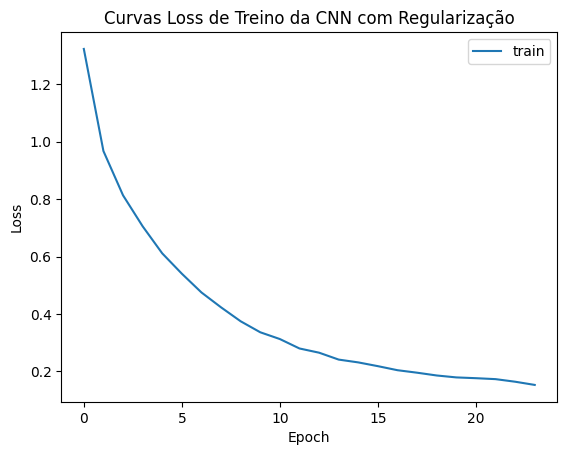

In [ ]:
#Plotando a curva de Loss do modelo CNN com os regularizadores
plt.plot(drop_cnn_loss_train, label="train")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.title("Curvas Loss de Treino da CNN com Regularização")
plt.show()

## Parte 3 - Acrescentando o Early Stopping

**Early Stopping (Parada precoce):** A parada precoce ou antecipada é uma técnica de otimização utilizada para reduzir o overfitting sem comprometer a precisão do modelo.
- A ideia principal da parada antecipada consiste em interromper o treino antes de um modelo começar a se ajustar excessivamente.

Há diferentes abordagens do Early Stopping:

- **1. Treinar o modelo num número predefinido de épocas**
- **2. Parar quando a atualização da função de perda se torna pequena**
- **3. Estratégia do conjunto de validação**

Mais detalhes em: https://www.educative.io/answers/what-is-early-stopping

Abaixo segue a implementação de uma classe do `Early Stopping` em `pytorch` utilizando a abordagem 2 citada acima.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}\n\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0


    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def net_training_early(model, epochs, optimizer, loss_function, train_loader, test_loader):

    patience = 5 #Quantidade de espera, caso não haja uma alteração da métrica loss
    early_stopping = EarlyStopping(patience = patience, verbose = True) #Instanciando o método do early stopping

    model.to(device)
    training_loss, testing_loss = [], []

    for epoch in range(1, epochs):
        model.train()
        running_loss = 0.0
        for batch_count, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            output = model(features)
            loss = loss_function(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()#Armazenando as loss em uma lista

        avg_train_loss = running_loss/batch_count
        avg_test_loss = net_validation(model, test_loader, loss_function)
        training_loss.append(avg_train_loss)
        testing_loss.append(avg_test_loss)

        print("Epoch:", epoch, "| Loss:", avg_train_loss)

        #Chamada do método early stopping
        early_stopping(avg_train_loss , model)
        if early_stopping.early_stop:
            print('Early stopping')
            break

        #Calculando a acurácia da rede
        model.eval()
        with torch.no_grad():
            print('Época: %03d/%03d acurácia de treinamento: %.2f%%' % (epoch, epochs,
                                                              net_accuracy(model, train_loader)))



    return training_loss, testing_loss

In [ ]:
#Utilzando como base a rede com regularização junto ao early stopping
cnn_with_early = CNN_Dropout()

#Função de custo/perda/loss
criterion = nn.CrossEntropyLoss()

#Taxa de aprendizagem
learning_rate = 0.001

#Optimizador
optimizer = optim.Adam(cnn_with_early.parameters(), lr = learning_rate)


start_time = time.time()
es_loss_train, es_loss_test = net_training_early(model = cnn_with_early,
                                                    epochs = num_epochs,
                                                    optimizer = optimizer,
                                                    loss_function = criterion,
                                                    train_loader = train_loader,
                                                    test_loader = test_loader
                                                    )

#Tempo total
print('\nTempo de treino total:: %.2f min' % ((time.time() - start_time)/60))

#Avaliação com o conjunto de teste
print('\nAcurácia do modelo no conjunto de teste: %.2f%%' % (net_accuracy(cnn_with_early, test_loader)))

Epoch: 1 | Loss: 1.3401991654665042
Validation loss decreased (inf --> 1.340199).  Saving model ...
Época: 001/025 acurácia de treinamento: 63.13%
Epoch: 2 | Loss: 0.9763333482620044
Validation loss decreased (1.340199 --> 0.976333).  Saving model ...
Época: 002/025 acurácia de treinamento: 72.21%
Epoch: 3 | Loss: 0.8143697113562853
Validation loss decreased (0.976333 --> 0.814370).  Saving model ...
Época: 003/025 acurácia de treinamento: 71.15%
Epoch: 4 | Loss: 0.7059120715428622
Validation loss decreased (0.814370 --> 0.705912).  Saving model ...
Época: 004/025 acurácia de treinamento: 81.24%
Epoch: 5 | Loss: 0.611235663600457
Validation loss decreased (0.705912 --> 0.611236).  Saving model ...
Época: 005/025 acurácia de treinamento: 82.59%
Epoch: 6 | Loss: 0.5402525981267293
Validation loss decreased (0.611236 --> 0.540253).  Saving model ...
Época: 006/025 acurácia de treinamento: 84.58%
Epoch: 7 | Loss: 0.4768548633043583
Validation loss decreased (0.540253 --> 0.476855).  Saving

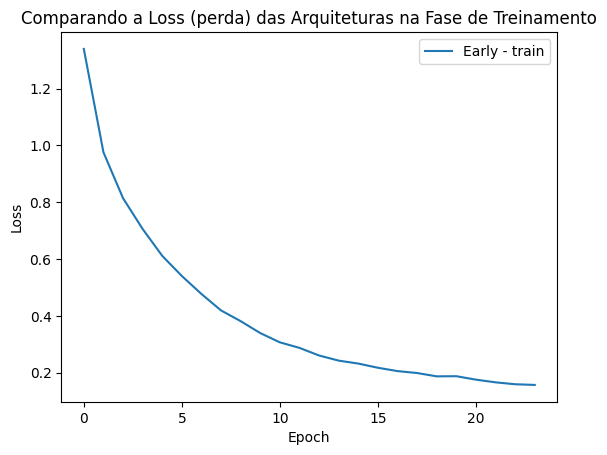

In [ ]:
plt.plot(es_loss_train, label="Early - train")
#plt.plot(es_loss_test, label="Early - test")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.title("Comparando a Loss (perda) das Arquiteturas na Fase de Treinamento")
plt.show()

## Parte 4 - Comparando todas as Loss de Treinamento

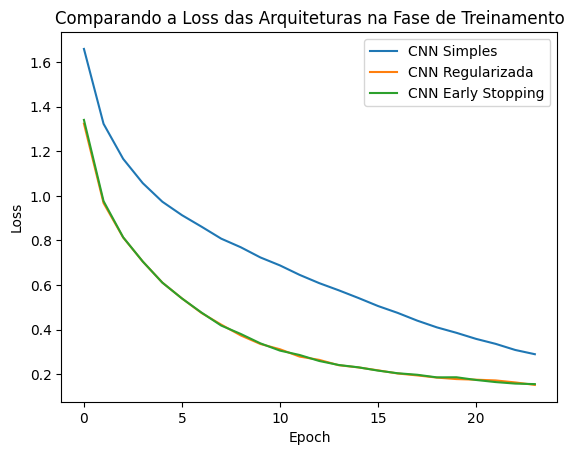

In [ ]:
plt.plot(simple_cnn_loss_train, label="CNN Simples")
plt.plot(drop_cnn_loss_train, label="CNN Regularizada")
plt.plot(es_loss_train, label="CNN Early Stopping")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.title("Comparando a Loss das Arquiteturas na Fase de Treinamento")
plt.show()

- Podemos perceber que neste cenário, a curva de treinamento do modelo com early stopping quase não se altera.
- Foi utilizado apenas 25 épocas, pode ser que esse comportamento seja diferente testando com mais épocas.
- Assim como, testando em cenários diferentes podemos ter de fato a parada precoce do treinamento da rede.

## Referências

- **Dropout: A Simple Way to Prevent Neural Networks from Overfitting:** https://jmlr.org/papers/v15/srivastava14a.html
- **Batch normalization in 3 levels of understanding:** https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338
- **pytorch early stop snippet:** https://www.kaggle.com/code/spacehedgehog/pytorch-early-stop-snippet
- **What is early stopping?:** https://www.educative.io/answers/what-is-early-stopping